In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from matplotlib import pyplot as plt

plt.style.use("ggplot")

In [8]:
POSITIVE_CLASS = 1
BAG_COUNT = 1000
VAL_BAG_COUNT = 300
BAG_SIZE = 3
PLOT_SIZE = 3
ENSEMBLE_AVG_COUNT = 1

In [9]:
def creat_bags(input_data, input_labels, positive_class, bag_count,  instance_count):
  bags = []
  bag_labels = []

  input_data = np.divide(input_data, 255.0)

  count = 0

  for _ in range(bag_count):
    index = np.random.choice(input_data.shape[0], instance_count, replace=False)
    instances_data = input_data[index]
    instances_labels = input_labels[index]

    bag_label = 0

    if positive_class in instances_labels:
      bag_label = 1
      count += 1

    bags.append(instances_data)
    bag_labels.append(np.array([bag_label]))
  
  print(f"Positive bags: {count}")
  print(f"Negative bags: {bag_count - count}")

  return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels))

(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()

train_data, train_labels = creat_bags(
    x_train, y_train, POSITIVE_CLASS, BAG_COUNT, BAG_SIZE
)


val_data, val_labels = creat_bags(
    x_val, y_val, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE
)

Positive bags: 300
Negative bags: 700
Positive bags: 82
Negative bags: 218


In [10]:
class MILAttentionLayer(layers.Layer):
  def __init__(
      self, 
      weight_params_dim,
      kernel_initializer="glorot_uniform",
      kernel_regularizer=None,
      use_gated=False,
      **kwargs,
  ):
    super().__init__(**kwargs)
    self.weight_params_dim = weight_params_dim
    self.use_gated = use_gated
    self.kernel_initializer = keras.initializers.get(kernel_initializer)
    self.kernel_regularizer = keras.regularizers.get(kernel_initializer)
    self.v_init = self.kernel_initializer
    self.w_init = self.kernel_initializer
    self.u_init = self.kernel_initializer
    self.v_regularizer = self.kernel_regularizer
    self.w_regularizer = self.kernel_regularizer
    self.u_regularizer = self.kernel_regularizer

  def build(self, input_shape):
    input_dim = input_shape[0][1]

    self.v_weight_params = self.add_weight(
        shape=(input_dim, self.weight_params_dim),
        initializer=self.v_init,
        name="v",
        regularizer=self.v_regularizer,
        trainable=True
    )

    self.w_weight_params = self.add_weight(
        shape=(self.weight_params_dim, 1),
        initializer=self.w_init,
        name="w",
        regularizer=self.w_regularizer,
        trainable=True,
    )

    if self.use_gated:
      self.u_weight_params = self.add_weight(
          shape=(input_dim, self.weight_params_dim),
          initializer=self.u_init,
          name="u",
          regularizer=self.u_regularizer,
          trainable=True,
      )
    else:
      self.input_built = True

  def call(self, inputs):
    instances = [self.compute_attention_scores(instance) for instance in inputs]
    alpha = tf.math.softmax(instances, axis=0)
    return [alpha[i] for i in range(alpha.shape[0])]

  def compute_attention_scores(self, instance):
    original_instance = instance
    instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))

    if self.use_gated:
      instance = instance * tf.math.sigmoid(
          tf.tensorfot(original_instance, self.u_weight_parans, axes=1)
      )
    
    return tf.tensordot(instance, self.w_weight_params, axes=1)

The bag class label is positive
Bag number:  6


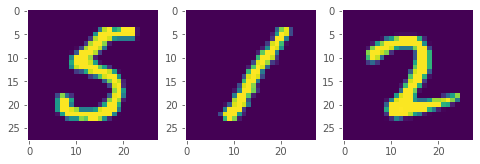

Bag number:  8


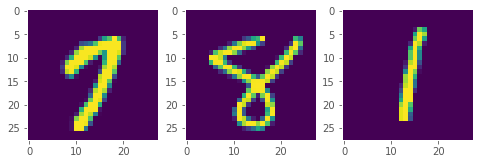

Bag number:  12


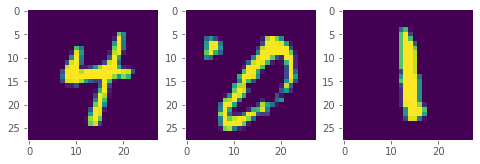

The bag class label is negative
Bag number:  0


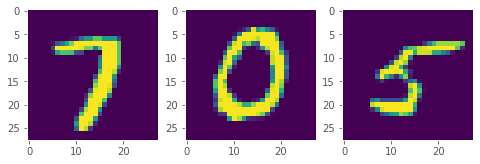

Bag number:  1


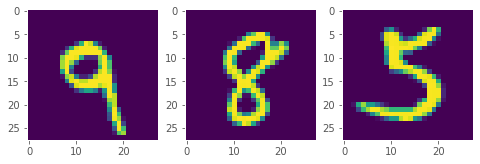

Bag number:  2


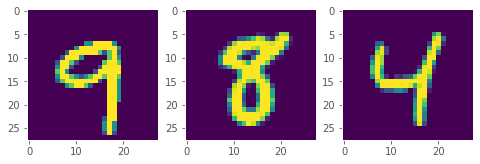

In [15]:
def plot(data, labels, bag_class, predictions=None, attention_weight=None):
  labels = np.array(labels).reshape(-1)

  if bag_class == "positive":
    if predictions is not None:
      labels = np.where(predictions.argmax(1) == 1)[0]
      bags = np.array(data)[:, labels[0:PLOT_SIZE]]
    else:
      labels = np.where(labels == 1)[0]
      bags = np.array(data)[:, labels[0:PLOT_SIZE]]

  elif bag_class == "negative":
    if predictions is not None:
      labels = np.where(predictions.argmax(1) == 0)[0]
      bags = np.array(data)[:, labels[0:PLOT_SIZE]]
    else:
      labels = np.where(labels == 0)[0]
      bags = np.array(data)[:, labels[0:PLOT_SIZE]]

  else:
    print(f"There is no class {bag_class}")
    return
  
  print(f"The bag class label is {bag_class}")
  for i in range(PLOT_SIZE):
    figure = plt.figure(figsize=(8, 8))
    print(f"Bag number:  {labels[i]}")
    for j in range(BAG_SIZE):
      image  = bags[j][i]
      figure.add_subplot(1, BAG_SIZE, j + 1)
      plt.grid(False)
      if attention_weight is not None:
        plt.title(np.around(attention_weight[labels[i]][j], 2))
      plt.imshow(image)
    plt.show()

plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")

In [24]:
def create_model(instance_shape):
  inputs, embeddings = [], []
  shared_dense_layer_1 = layers.Dense(128, activation='relu')
  shared_dense_layer_2 = layers.Dense(64, activation='relu')

  for _ in range(BAG_SIZE):
    inp = layers.Input(instance_shape)
    flatten = layers.Flatten()(inp)
    dense_1 = shared_dense_layer_1(flatten)
    dense_2 = shared_dense_layer_2(dense_1)
    inputs.append(inp)
    embeddings.append(dense_2)
  
  alpha = MILAttentionLayer(
      weight_params_dim=256,
      kernel_regularizer=keras.regularizers.l2(0.01),
      use_gated=True,
      name="alpha",
  )(embeddings)

  multiply_layers = [
                     layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))
  ]

  concat = layers.concatenate(multiply_layers, axis=1)

  outputs = layers.Dense(2, activaiton='softmax')(concat)

  return keras.Model(inputs, outputs)

In [19]:
def compuute_class_weights(labels):
  negative_count = len(np.where(labels == 0)[0])
  positive_count = len(np.where(labels == 1)[0])
  total_count = negative_count + positive_count

  return {
      0: (1 / negative_count) * (total_count / 2),
      1: (1 / positive_count) * (total_count / 2),
  }

In [21]:
def train(train_data, train_labels, val_data, val_labels, model):
  file_path = '/content/drive/MyDrive/best_model_weights.h5'

  model_checkpoint = keras.callbaks.ModelCheckpoint(
      file_path,
      moniter='val_loss',
      verbose=0,
      mode='min',
      save_best_only=True,
      save_weights_only=True,
  )

  early_stopping = keras.callbacks.EarlyStopping(
      moniter='val_loss', patience=10, mode='min'
  )

  model.compile(
      optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']
  )

  model.fit(
      train_data,
      train_labels,
      validation_data=(val_data, val_labels),
      epochs=20,
      class_weight=compuute_class_weights(train_labels),
      batch_size=1,
      callbacks=[early_stopping, model_checkpoint],
      verbose=0,
  )

  model.load_weights(file_path)

  return model

In [26]:
instance_shape = train_data[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_AVG_COUNT)]

print(models[0].summary())

In [ ]:
trained_models = [
    train(train_data, train_labels, val_data, val_labels, model)
    for model in tqdm(models)
]